In [9]:
import numpy as np

# Define the dimensionality of our problem.
ndim = 5

# Define our 3-D correlated multivariate normal likelihood.
C = np.identity(ndim)  # set covariance to identity matrix
C[C==0] = 0.95  # set off-diagonal terms
Cinv = np.linalg.inv(C)  # define the inverse (i.e. the precision matrix)
lnorm = -0.5 * (np.log(2 * np.pi) * ndim +
                np.log(np.linalg.det(C)))  # ln(normalization)

def loglike(x):
    """The log-likelihood function."""

    return -0.5 * np.dot(x, np.dot(Cinv, x)) + lnorm

# Define our uniform prior.
def ptform(u):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our uniform prior within [-10., 10.) for each variable."""

    return 10. * (2. * u - 1.)

Similar to ensemble sampling methods such as 
`emcee`<http://dan.iel.fm/emcee/current/>, the behavior of Nested Sampling
can also be sensitive to the number of live points used. Increasing the number
of live points leads to smaller changes in the prior volume $\ln X$ over
time. This improves the effective resolution while simultaneously increasing
the runtime.

The number of live points can be specified upon initialization via the 
`nlive` argument. For example, if we want to run with 1000 live points rather
than the default 250, we would use::

    NestedSampler(loglike, ptform, ndim, nlive=1500)


In [2]:
import dynesty

# "Static" nested sampling.
sampler = dynesty.NestedSampler(loglike, ptform, ndim, bound='balls')
sampler.run_nested()
sresults = sampler.results

# "Dynamic" nested sampling.
dsampler = dynesty.DynamicNestedSampler(loglike, ptform, ndim)
dsampler.run_nested()
dresults = dsampler.results

C:\Users\Marco Immanuel\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
4763it [00:06, 693.63it/s, +500 | bound: 9 | nc: 1 | ncall: 25018 | eff(%): 21.466 | loglstar:   -inf < -0.297 <    inf | logz: -9.035 +/-  0.128 | dlogz:  0.001 >  0.509]
14658it [00:12, 1217.16it/s, batch: 7 | bound: 1 | nc: 1 | ncall: 37663 | eff(%): 38.770 | loglstar: -5.782 < -0.312 < -5.298 | logz: -8.729 +/-  0.071 | stop:  0.973]              


Out::

    iter: 12521 | +1500 | bound: 7 | nc: 1 | ncall: 66884 | eff(%): 20.963 |
    loglstar:   -inf < -0.301 <    inf | logz: -8.960 +/-  0.082 |
    dlogz:  0.001 >  1.509                                        

From left to right, this records: the current iteration (plus the number of
live points added after stopping), the current bound being used, the number
of log-likelihood calls made before accepting the last sample, the total number
of log-likelihood calls, the overall sampling efficiency, 
the current log-likelihood bounds (`-inf` and `inf`
because we began sampling from the prior and didn't declare a `logl_max`),
the current estimated evidence, and the remaining `dlogz` relative
to the stopping criterion.


In [3]:
from dynesty import utils as dyfunc

# Combine results from "Static" and "Dynamic" runs.
results = dyfunc.merge_runs([sresults, dresults])

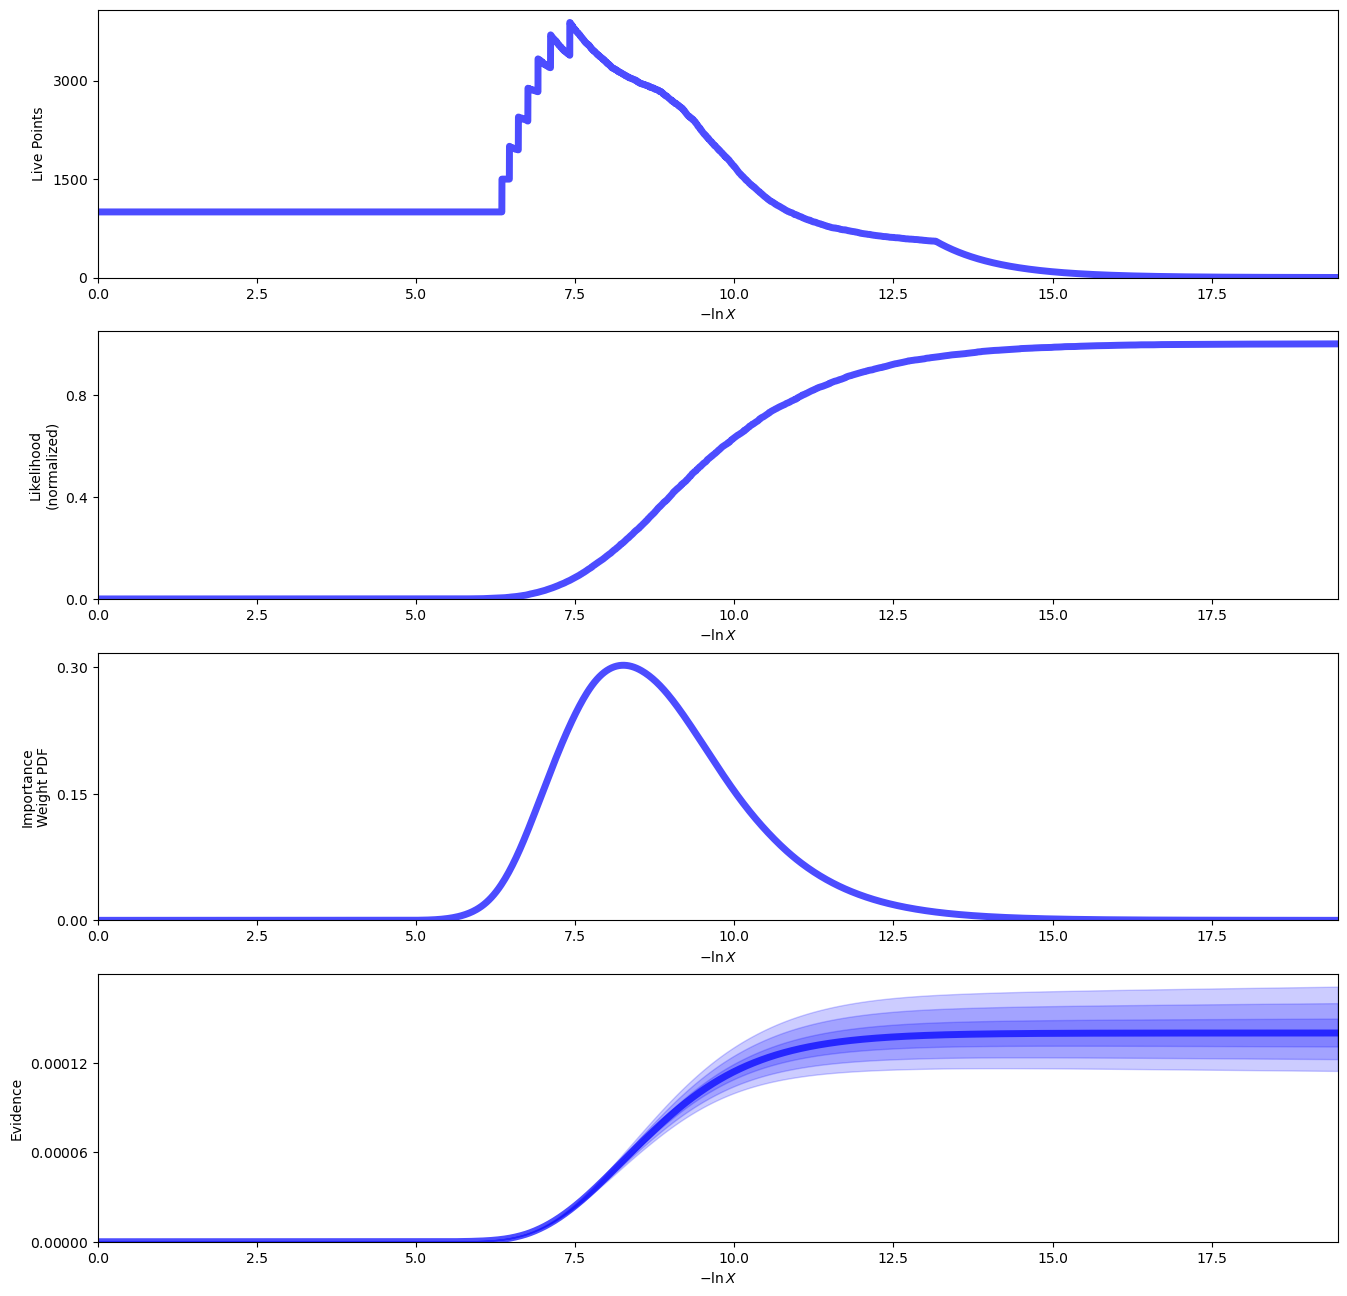

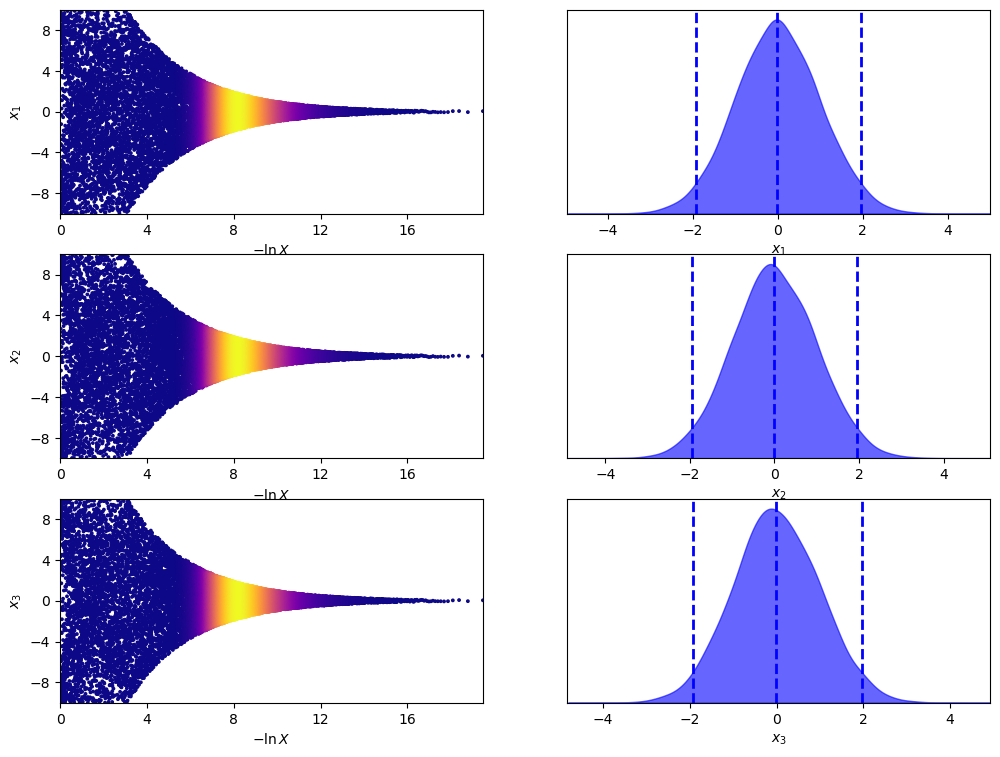

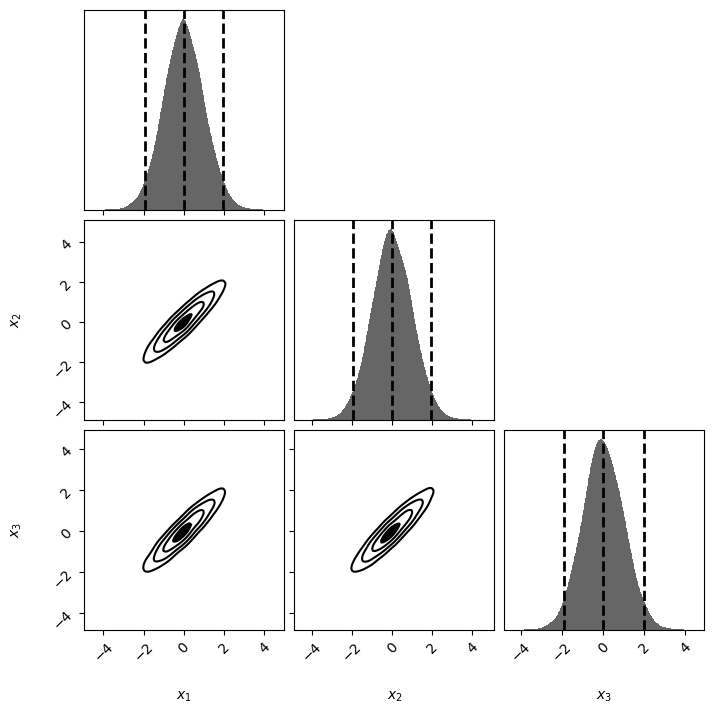

In [4]:
from dynesty import plotting as dyplot

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(results)

# Plot traces and 1-D marginalized posteriors.
tfig, taxes = dyplot.traceplot(results)

# Plot the 2-D marginalized posteriors.
cfig, caxes = dyplot.cornerplot(results)

In [5]:
from dynesty import utils as dyfunc

# Extract sampling results.
samples = results.samples  # samples
weights = results.importance_weights()

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.1, 0.9], weights=weights)
             for samps in samples.T]

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)

# Resample weighted samples.
samples_equal = results.samples_equal()

# Generate a new set of results with sampling uncertainties.
results_sim = dyfunc.resample_run(results)

In [7]:
print(dsampler.citations)

Code and Methods:
Speagle (2020): ui.adsabs.harvard.edu/abs/2020MNRAS.493.3132S
Koposov et al. (2023): doi.org/10.5281/zenodo.3348367

Nested Sampling:
Skilling (2004): ui.adsabs.harvard.edu/abs/2004AIPC..735..395S
Skilling (2006): projecteuclid.org/euclid.ba/1340370944
Dynamic Nested Sampling:
Higson et al. (2019): doi.org/10.1007/s11222-018-9844-0

Bounding Method:
Feroz, Hobson & Bridges (2009): ui.adsabs.harvard.edu/abs/2009MNRAS.398.1601F

Sampling Method:




# More complicated priors

In [10]:
import scipy

def prior_transform(u):
    """Transforms the uniform random variables `u ~ Unif[0., 1.)`
    to the parameters of interest."""

    x = np.array(u)  # copy u

    # Bivariate Normal
    t = scipy.stats.norm.ppf(u[0:2])  # convert to standard normal
    Csqrt = np.array([[2., 1.],
                      [1., 2.]])  # C^1/2 for C=((5, 4), (4, 5))
    x[0:2] = np.dot(Csqrt, t)  # correlate with appropriate covariance
    mu = np.array([5., 2.])  # mean
    x[0:2] += mu  # add mean

    # Beta
    a, b = 2.31, 0.627  # shape parameters
    x[2] = scipy.stats.beta.ppf(u[2], a, b)

    # Gamma
    alpha = 5.  # shape parameter
    x[3] = scipy.stats.gamma.ppf(u[3], alpha)

    # Truncated Normal
    m, s = 5, 2  # mean and standard deviation
    low, high = 2., 10.  # lower and upper bounds
    low_n, high_n = (low - m) / s, (high - m) / s  # standardize
    x[4] = scipy.stats.truncnorm.ppf(u[4], low_n, high_n, loc=m, scale=s)

    return x

In [11]:
# "Static" nested sampling.
trysampler = dynesty.NestedSampler(loglike, prior_transform, ndim, bound='balls')
trysampler.run_nested()
trysresults = trysampler.results

8208it [00:57, 141.97it/s, +500 | bound: 30 | nc: 1 | ncall: 41127 | eff(%): 21.434 | loglstar:   -inf < -5.762 <    inf | logz: -21.519 +/-  0.180 | dlogz:  0.001 >  0.509]


In [12]:
# "Static" nested sampling.
trysampler = dynesty.NestedSampler(loglike, prior_transform, ndim, bound='multi', sample='slice')
trysampler.run_nested()
trysresults = trysampler.results

3744it [02:06, 15.32it/s, bound: 23 | nc: 84 | ncall: 170649 | eff(%):  2.194 | loglstar:   -inf < -31.259 <    inf | logz: -40.671 +/-  0.130 | dlogz: 24.087 >  0.509] Traceback (most recent call last):
  File "C:\Users\Marco Immanuel\anaconda3\lib\site-packages\dynesty\dynesty.py", line 910, in __call__
    return self.func(np.asarray(x).copy(), *self.args, **self.kwargs)
  File "C:\Users\Marco Immanuel\AppData\Local\Temp\ipykernel_28676\3785704511.py", line 13, in prior_transform
    x[0:2] = np.dot(Csqrt, t)  # correlate with appropriate covariance
KeyboardInterrupt
3744it [02:06, 29.65it/s, bound: 23 | nc: 84 | ncall: 170649 | eff(%):  2.194 | loglstar:   -inf < -31.259 <    inf | logz: -40.671 +/-  0.130 | dlogz: 24.087 >  0.509]

Exception while calling prior_transform function:
  params: [0.07903175 0.7430673  0.38003308 0.08117984 0.03124151]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [13]:
# "Static" nested sampling.
trysampler = dynesty.NestedSampler(loglike, prior_transform, ndim, nlive=1500, bound='balls')
trysampler.run_nested()
trysresults = trysampler.results

22635it [03:24, 110.85it/s, +1500 | bound: 23 | nc: 1 | ncall: 104802 | eff(%): 23.364 | loglstar:   -inf < -5.629 <    inf | logz: -21.449 +/-  0.130 | dlogz:  0.001 >  1.509]
